In [11]:
import torch
from torchvision import datasets, transforms
import torch.autograd 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from numba import vectorize,cuda
import random 
import time
import math

train_loader= torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=64, shuffle=True) 
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=64, shuffle=True) 

MaxEpoch=20

accuracy_train_1 =np.zeros(int(MaxEpoch/3)+1)
accuracy_test_1 = np.zeros(int(MaxEpoch/3)+1)

accuracy_train_2 =np.zeros(int(MaxEpoch/3)+1)
accuracy_test_2 = np.zeros(int(MaxEpoch/3)+1)

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class Highway(nn.Module):
    def __init__(self, size_entrance, size, size_exit, num_layers, f):
        
        super(Highway, self).__init__()

        self.num_layers = num_layers

        self.nonlinear = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])

        self.linear = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])

        self.gate = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])

        self.f = f

        self.first=nn.Linear(size_entrance,size)
        
        self.last=nn.Linear(size,size_exit)
        
    def forward(self, x):
        x  =self.f(self.first(x))
        for layer in range(self.num_layers):
            gate = F.sigmoid(self.gate[layer](x))

            nonlinear = self.f(self.nonlinear[layer](x))
            linear = self.linear[layer](x)

            x = gate * nonlinear + (1 - gate) * linear

        return torch.log(F.softmax(self.last(x)))

    
class Model(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.m=nn.Linear(784,10)
        
    def forward(self,x):
        return(F.tanh(self.m((x))))

The Gradient descent took 4.988 min


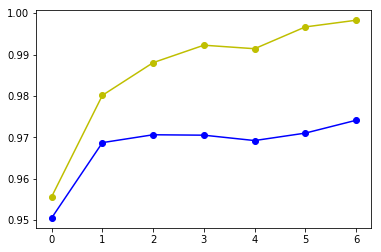

La valeur d'accuracy en test à la dernière itération est de 0.9741


In [13]:
hw = Highway(size_entrance=28*28,
             size=50,
             size_exit=10,
             num_layers=2, 
             f=F.tanh)

l = nn.NLLLoss()
optimizer1 = torch.optim.Adamax(hw.parameters(),lr=0.005)

r=0

start=time.time()
for iteration in range(MaxEpoch) :   
    for x,y in train_loader:
        optimizer1.zero_grad()
       
        inp=x.view(x.size()[0],784)
        inp=Variable(inp)
        
        out= hw.forward(inp)
        err =l.forward(out,Variable(y))
        err.backward()
        
        optimizer1.step()
        

    if(iteration%3==0):
        for x1,y1 in train_loader:
            x1= Variable(x1.view(x1.size()[0],28*28))
            y1= Variable(y1)
            a= sum(torch.max(hw.forward(x1).t(),0)[1]==y1)
            accuracy_train_1[r] += a.data[0]
        accuracy_train_1[r] /= train_loader.dataset.train_data.size()[0]

        for x1,y1 in test_loader:
            x1= Variable(x1.view(x1.size()[0],28*28))
            y1= Variable(y1)
            a= sum(torch.max(hw.forward(x1).t(),0)[1]==y1)
            accuracy_test_1[r] += a.data[0]
        accuracy_test_1[r] /= test_loader.dataset.test_data.size()[0]
        r+=1

print('The Gradient descent took '+ str(round((time.time()-start)/60,3))+' min')
import matplotlib.pyplot as plt

plt.plot(accuracy_train_1,'y',marker='o')
plt.plot(accuracy_test_1,'b',marker='o')
plt.show()

print("La valeur d'accuracy en test à la dernière itération est de " + str(accuracy_test_1[r-1]))

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class neural_net(nn.Module):
    def __init__(self, num_layers, size_list, f):

        super(neural_net, self).__init__()

        self.num_layers = num_layers

        self.linear = nn.ModuleList([nn.Linear(size_list[i], size_list[i+1]) for i in range(num_layers)])

        self.f = f

    def forward(self, x):
        
        for layer in range(self.num_layers):
            
            x =self.f(self.linear[layer](x))
             
        return x


The Gradient descent took 7.381 min


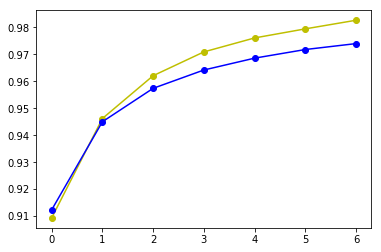

La valeur d'accuracy en test à la dernière itération est de 0.974


In [15]:
lm = neural_net(2,[784,500,10],F.tanh)

l = nn.NLLLoss()
optimizer = torch.optim.Adamax(lm.parameters(),lr=0.0002)

r=0

start=time.time()
for iteration in range(MaxEpoch) :   
    for x,y in train_loader:
        optimizer.zero_grad()
        
        inp=x.view(x.size()[0],784)
        inp=Variable(inp)
        
        out= lm.forward(inp)
        
        err =l.forward(torch.log(F.softmax(out)),Variable(y))
        err.backward()
        
        optimizer.step()


    if(iteration%3==0):
        for x1,y1 in train_loader:
            x1= Variable(x1.view(x1.size()[0],28*28))
            y1= Variable(y1)
            a= sum(torch.max(lm.forward(x1).t(),0)[1]==y1)
            accuracy_train_2[r] += a.data[0]
        accuracy_train_2[r] /= train_loader.dataset.train_data.size()[0]

        for x1,y1 in test_loader:
            x1= Variable(x1.view(x1.size()[0],28*28))
            y1= Variable(y1)
            a= sum(torch.max(lm.forward(x1).t(),0)[1]==y1)
            accuracy_test_2[r] += a.data[0]
        accuracy_test_2[r] /= test_loader.dataset.test_data.size()[0]
        r+=1

print('The Gradient descent took '+ str(round((time.time()-start)/60,3))+' min')
import matplotlib.pyplot as plt

plt.plot(accuracy_train_2,'y',marker='o')
plt.plot(accuracy_test_2,'b',marker='o')
plt.show()

print("La valeur d'accuracy en test à la dernière itération est de " + str(accuracy_test_2[r-1]))


In [21]:
MaxEpoch = 20

accuracy_train_1 =np.zeros(int(MaxEpoch/3)+1)
accuracy_test_1 = np.zeros(int(MaxEpoch/3)+1)

accuracy_train_2 =np.zeros(int(MaxEpoch/3)+1)
accuracy_test_2 = np.zeros(int(MaxEpoch/3)+1)


In [ ]:
hw = Highway(size_entrance=28*28,
             size=50,
             size_exit=10,
             num_layers=5, 
            f =torch.nn.functional.relu)

l = nn.NLLLoss()
optimizer1 = torch.optim.Adamax(hw.parameters(),lr=0.003)

r=0

start=time.time()
for iteration in range(MaxEpoch) :   
    for x,y in train_loader:
        optimizer1.zero_grad()
       
        inp=x.view(x.size()[0],784)
        inp=Variable(inp)
        
        out= hw.forward(inp)
        err =l.forward(out,Variable(y))
        err.backward()
        
        optimizer1.step()
        

    if(iteration%3==0):
        for x1,y1 in train_loader:
            x1= Variable(x1.view(x1.size()[0],28*28))
            y1= Variable(y1)
            a= sum(torch.max(hw.forward(x1).t(),0)[1]==y1)
            accuracy_train_1[r] += a.data[0]
        accuracy_train_1[r] /= train_loader.dataset.train_data.size()[0]

        for x1,y1 in test_loader:
            x1= Variable(x1.view(x1.size()[0],28*28))
            y1= Variable(y1)
            a= sum(torch.max(hw.forward(x1).t(),0)[1]==y1)
            accuracy_test_1[r] += a.data[0]
        accuracy_test_1[r] /= test_loader.dataset.test_data.size()[0]
        r+=1

print('The Gradient descent took '+ str(round((time.time()-start)/60,3))+' min')
import matplotlib.pyplot as plt

plt.plot(accuracy_train_1,'y',marker='o')
plt.plot(accuracy_test_1,'b',marker='o')
plt.show()

print("La valeur d'accuracy en test à la dernière itération est de " + str(accuracy_test_1[r-1]))

## Je n'arrive pas à trouver les bons paramètres (learning rate, poids des mudules à l'initialisation)

In [41]:
accuracy_train_1

array([ 0.75746667,  0.8994    ,  0.90253333,  0.917     ,  0.9416    ,
        0.9472    ,  0.95313333,  0.96565   ,  0.96846667,  0.97635   ,
        0.97838333,  0.98006667,  0.9854    ,  0.98613333,  0.98958333,
        0.99043333,  0.9874    ,  0.99081667,  0.99356667,  0.9925    ])

The Gradient descent took 23.425 min


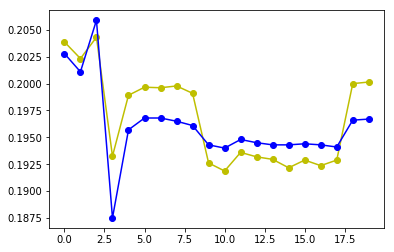

La valeur d'accuracy en test à la dernière itération est de 0.1967


In [40]:
lm = neural_net(30,[784,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,
        50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,
        50,  50,  50,  50,  10],F.tanh)


l = nn.NLLLoss()
optimizer = torch.optim.Adamax(lm.parameters(),lr=0.0002)

r=0

start=time.time()
for iteration in range(MaxEpoch) :   
    for x,y in train_loader:
        optimizer.zero_grad()
        
        inp=x.view(x.size()[0],784)
        inp=Variable(inp)
        
        out= lm.forward(inp)
        
        err =l.forward(torch.log(F.softmax(out)),Variable(y))
        err.backward()
        
        optimizer.step()


    if(iteration%3==0):
        for x1,y1 in train_loader:
            x1= Variable(x1.view(x1.size()[0],28*28))
            y1= Variable(y1)
            a= sum(torch.max(lm.forward(x1).t(),0)[1]==y1)
            accuracy_train_2[r] += a.data[0]
        accuracy_train_2[r] /= train_loader.dataset.train_data.size()[0]

        for x1,y1 in test_loader:
            x1= Variable(x1.view(x1.size()[0],28*28))
            y1= Variable(y1)
            a= sum(torch.max(lm.forward(x1).t(),0)[1]==y1)
            accuracy_test_2[r] += a.data[0]
        accuracy_test_2[r] /= test_loader.dataset.test_data.size()[0]
        r+=1

print('The Gradient descent took '+ str(round((time.time()-start)/60,3))+' min')
import matplotlib.pyplot as plt

plt.plot(accuracy_train_2,'y',marker='o')
plt.plot(accuracy_test_2,'b',marker='o')
plt.show()

print("La valeur d'accuracy en test à la dernière itération est de " + str(accuracy_test_2[r-1]))
